"Experimental Bayesian Calibration of Trapped-Ion Entangling Operations" (https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.3.020350).

Original noise parameters ($\sigma_\Omega, \sigma_\Delta, \sigma_\epsilon, \sigma_\varphi$) based on the original paper (see Fig. 4)

Derivative noise parameters ($\sigma_I, \sigma_{f_{cl}}, \sigma_{f_{sb}}$) based on **single_qubit_rotations/single_qubit_noise_sim.ipynb**.

In [36]:
# Run this cell to test if the LinearChain object is gonna give us a headache.
using IonSim

@time chain = LinearChain(
        ions=[Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")]), Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])], 
        comfrequencies=(x=3e6,y=3e6,z=2.5e5), selectedmodes=(;z=[1],)
    )
chain = Nothing;

  0.225477 seconds (200.93 k allocations: 12.525 MiB)


In [57]:
using QuantumOptics
import PyPlot
using Random, Distributions
using ProgressBars
Random.seed!(0)

include("./molmer_sorensen.jl")
using .MolmerSorensen: construct_MS_chamber
const plt = PyPlot;

using JLD2

The Molmer-Sorensen Hamiltonian: $\hat{H} = \frac{\Omega(t)}{2} \sum_{i=1,2} \Bigg[ \bigg( \hat{\sigma}_+^{(1)} + \hat{\sigma}_+^{(2)} \bigg) \otimes e^{i[\eta(\hat{a} e^{-i\nu t} + \hat{a}^\dagger e^{i \nu t} ) - \Delta_i t + \phi_i ) ] } \Bigg] + h.c.$

## 0. Setup

Global variables

In [63]:
σ_f_cl

2000.0

In [38]:
######################### Intensity #########################
μ_I = 94326.65907221894 # W/cm^2
σ_I = 38106.10236476285 # W/cm^2
Normal_I = Normal(μ_I, σ_I)

######################### Trap frequency #########################
μ_ν = 2.5e5 # Hz
σ_ν = 2e3 # Hz
Normal_ν = Normal(μ_ν, σ_ν)

######################### Center-line frequency #########################
C0 = 2.99792458e8
δλ_MAX = 1e-15
μ_f_cl = 4.111550352057269e14 # Hz
σ_f_cl = 2e3 # Hz
Normal_f_cl = Normal(μ_f_cl, σ_f_cl)

######################### Phase #########################
μ_ϕ = 0
σ_ϕ = 0.16*π
Normal_ϕ = Normal(μ_ϕ, σ_ϕ)

######################### Other chamber parameters #########################
DETUNING = 1e4 # Hz
AC_CORRECTION = 0; # Hz
B_STRENGTH = 0.0005999899999999999; # T

GATE_TIME = 1/DETUNING # seconds
T_RANGE = 0:GATE_TIME*1e-3:GATE_TIME
TIMESCALE = 1e-6 # seconds 

######################### Other global variables #########################

CALCIUM40 = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])
N_PARTICLES = Int(1e3)
FINITE_RWA_CUTOFF = 1e5

# Intialize chamber object, whose properties will be updated in the loop
MS_CHAMBER_TUNED = construct_MS_chamber(
    μ_ν
    μ_I
    C0/μ_f_cl,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)

ket0_VIB_MODE = IonSim.modes(MS_CHAMBER_TUNED)[1] # ground state of first vibrational mode
dm0_VIB_MODE = dm(ket0_VIB_MODE)

# Computational states 
ket_00 = CALCIUM40["S"] ⊗ CALCIUM40["S"]
ket_01 = CALCIUM40["S"] ⊗ CALCIUM40["D"]
ket_10 = CALCIUM40["D"] ⊗ CALCIUM40["S"]
ket_11 = CALCIUM40["D"] ⊗ CALCIUM40["D"]
ρ_00 = dm(ket_00)
ρ_01 = dm(ket_01)
ρ_10 = dm(ket_10)
ρ_11 = dm(ket_11)

# Bell states 
ket_00_m_i11 = (ket_00 - 1im*ket_11)/√2
ket_00_p_i11 = (ket_00 + 1im*ket_11)/√2
ket_01_m_i10 = (ket_01 - 1im*ket_10)/√2
ket_01_p_i10 = (ket_01 + 1im*ket_10)/√2
ρ_00_m_i11 = dm(ket_00_m_i11)
ρ_00_p_i11 = dm(ket_00_p_i11)
ρ_01_m_i10 = dm(ket_01_m_i10)
ρ_01_p_i10 = dm(ket_01_p_i10);

Helper functions 

In [39]:
# For loading CSV's into matrices 

function load_csv_to_matrix(fname)
    data = readdlm(fname)
    data = [split(line, ",") for line in data]
    data = [[parse(Float64, elem) for elem in row] for row in data]

    matrix = zeros((length(data), length(data[1])))
    for i in 1:length(data)
        matrix[i,:] = [elem for elem in data[i]]
    end
    return matrix
end

# For measuring ZZ
function ZZ_probs(ψf) # random projective measurement onto the computational basis
    p_00 = real(tr(ρ_00 * ψf))
    p_11 = real(tr(ρ_11 * ψf))
    p_01 = real(tr(ρ_01 * ψf))
    p_10 = real(tr(ρ_10 * ψf))

    return p_00, p_11, p_01, p_10
end

# For plotting state populations 

function plot_populations_double(chamber, tout, sol; title = Nothing)

    # compute expectation values
    prob_00 = expect(ρ_00 ⊗ dm0_VIB_MODE , sol)  # 𝔼(|S⟩|S⟩)
    prob_11 = expect(ρ_11 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|D⟩|D⟩)
    prob_01 = expect(ρ_01 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|S⟩|D⟩)
    prob_10 = expect(ρ_10 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|D⟩|S⟩)
    prob_00_p_i11 = expect(ρ_00_p_i11 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|S⟩|S⟩ + i|D⟩|D⟩)
    prob_00_m_i11 = expect(ρ_00_m_i11 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|S⟩|S⟩ - i|D⟩|D⟩)
    prob_01_p_i10 = expect(ρ_01_p_i10 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|S⟩|D⟩ + i|D⟩|S⟩)
    prob_01_m_i10 = expect(ρ_01_m_i10 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|S⟩|D⟩ - i|D⟩|S⟩)

    # plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(tout, prob_00, label="00")
    ax1.plot(tout, prob_11, label="11")
    ax1.plot(tout, prob_01, label="01")
    ax1.plot(tout, prob_10, label="10")
    ax1.set_xlim(tout[1], tout[end])
    ax1.set_ylim(0, 1)
    ax1.legend(loc=1)
    ax1.set_xlabel("Time (μs)")
    ax1.set_ylabel("Population")
    ax1.set_title("Computational basis states")

    ax2.plot(tout, prob_00_p_i11, label="00 + i11")
    ax2.plot(tout, prob_00_m_i11, label="00 - i11")
    ax2.plot(tout, prob_01_p_i10, label="01 + i10")
    ax2.plot(tout, prob_01_m_i10, label="01 - i10")
    ax2.set_xlim(tout[1], tout[end])
    ax2.set_ylim(0, 1)
    ax2.legend(loc=1)
    ax2.set_xlabel("Time (μs)")
    ax2.set_ylabel("Population")
    ax2.set_title("Bell states")
    if title != Nothing
        fig.suptitle(title)
    end

    return fig
end

# For binning probability distributions
function bin_prior(particles, weights, n_bins)
    new_bins = zeros(n_bins)
    new_weights = zeros(n_bins)
    bin_width = (maximum(particles) - minimum(particles))/n_bins
    
    for i in 1:n_bins
        bin_start = minimum(particles) + (i-1)*bin_width
        bin_end = bin_start + bin_width
        new_bins[i] = mean([bin_start, bin_end])

        bin_filter = (particles .>= bin_start).&(particles .< bin_end)
        weight_in_bin = sum(weights[bin_filter])
        new_weights[i] = weight_in_bin
        
    end
    return new_bins, new_weights, bin_width
end

bin_prior (generic function with 1 method)

Test fidelity with optimal parameters

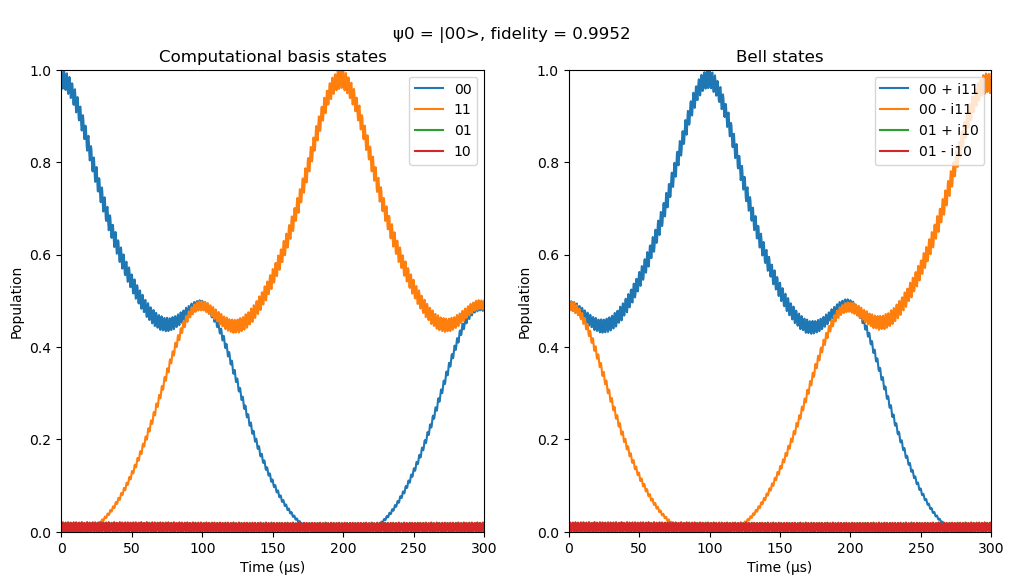

  0.500549 seconds (5.23 M allocations: 198.410 MiB, 6.92% gc time)
  0.279258 seconds (5.04 M allocations: 191.390 MiB, 9.91% gc time)


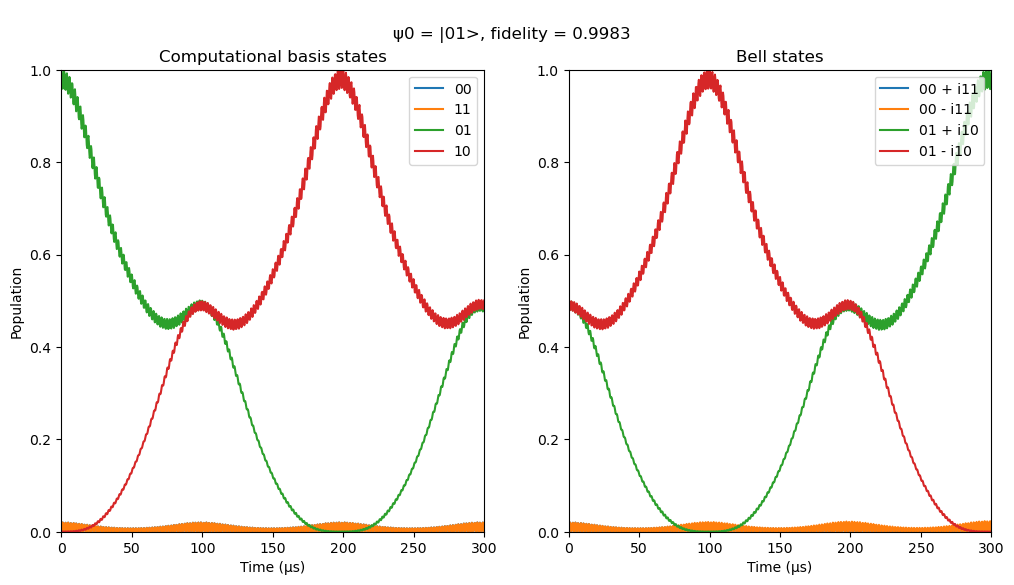

In [40]:
phase!(MS_CHAMBER_TUNED.lasers[1], 0)
phase!(MS_CHAMBER_TUNED.lasers[2], 0)

h = hamiltonian(MS_CHAMBER_TUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf);

@time tout00, sol00 = timeevolution.schroedinger_dynamic(3*T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h);
ρ_final = ptrace(dm(sol00[end]), 3)
fid = round(real(fidelity(ρ_final, ρ_00_m_i11)), digits=4)
fig = plot_populations_double(MS_CHAMBER_TUNED, tout00, sol00)
fig.suptitle("\nψ0 = |00>, fidelity = $fid")
plt.display(fig)
plt.close(fig)

@time tout01, sol01 = timeevolution.schroedinger_dynamic(3*T_RANGE/TIMESCALE, ket_01 ⊗ ket0_VIB_MODE , h);
ρ_final = ptrace(dm(sol01[end]), 3)

fid = round(real(fidelity(ρ_final, ρ_01_p_i10)), digits=4)
fig = plot_populations_double(MS_CHAMBER_TUNED, tout01, sol01)
fig.suptitle("\nψ0 = |01>, fidelity = $fid")
plt.display(fig)
plt.close(fig)

Functions to update true parameters, given measured parameters

### 1. Intensity
$\kappa = \frac{I}{\Omega^2} \Longrightarrow \Omega^2 = \frac{I}{\kappa} \Longrightarrow \Omega = \sqrt{\frac{I}{\kappa}}$

$\frac{\Omega_{\text{opt}}}{\overline{\Omega}} = \frac{\sqrt{I_{\text{opt}}/\kappa}}{\sqrt{\overline{I}/\kappa}} = \sqrt{\frac{I_{\text{opt}}}{\overline{I}}}$

In the text, they update: $t_g \to t_g \frac{\Omega_{\text{opt}}}{\overline{\Omega}}$

Since $t_g \sim I$, here we will update: $\boxed{I \to I \sqrt{\frac{I_{\text{opt}}}{\overline{I}}}}$

### 2. Center-line frequency

In the text, they update: $f_{\text{cl}} \to f_{\text{cl}} - (  \overline{\omega}_{\text{cl}} - \omega_{\text{cl, opt}} )$. 

**Mind the confusing notation**: here, $\omega_{\text{cl}}$ is not an angular frequency, they just use $\omega$ to denote the center-line *detuning* as opposed to the center-line frequency. With this in mind, it's clear that $\overline{\omega}_{\text{cl}} - \omega_{\text{cl, opt}}$ is exactly equivalent to $ \overline{f}_{\text{cl}} - f_{\text{cl, opt}}$. 

So we will update: $\boxed{f_{\text{cl}} \to f_{\text{cl}} - ( \overline{f}_{\text{cl}} - f_{\text{cl, opt}} )}$

### 3. Trap-frequency

In the text, they update: $f_{\text{sb}} \to f_{\text{sb}} - ( \overline{\delta} - \delta_{\text{opt}})$

So, once again, we simply update: $\boxed{\nu \to \nu - (\overline{\nu} - \nu_{\text{opt}})}$

### 4. Phase

 $\boxed{\varphi \to \varphi - (\overline{\Delta \varphi} - \Delta \varphi_{\text{opt}})}$

In [41]:
# Intensity
function compute_I_new(chamber, I_bar)
    I = chamber.lasers[1].I(0)
    return I*sqrt(INTENSITY_MS/I_bar)
end

function update_intensity(chamber, I_new)
    intensity!(chamber.lasers[1], I_new)
    intensity!(chamber.lasers[2], I_new)
end

# Center-line frequency 
function compute_f_cl_new(chamber, f_cl_bar)
    λ_cl = chamber.lasers[1].λ
    f_cl = C0/λ_cl
    return f_cl - (f_cl_bar - FREQUENCY_CL_MS)
end

function update_f_cl(chamber, f_cl_new)
    wavelength!(chamber.lasers[1], C0/f_cl_new)
    wavelength!(chamber.lasers[2], C0/f_cl_new)
end

# Trap-frequency
function compute_ν_new(chamber, ν_bar)
    ν = chamber.iontrap.comfrequencies.z
    return ν - (ν_bar - TRAP_FREQUENCY)
end

function update_ν(chamber, ν_new)
    # Can't update the trap-frequency in-place
    # Must create a brand new chamber, with all the same properties except for the trap frequency
    I = chamber.lasers[1].I(0)
    λ_cl = chamber.lasers[1].λ
    chamber_new = construct_MS_chamber(
        ν_new,
        I,
        λ_cl,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH
    )

    # Recall: The detuning is based on the *target* trap-frequency
    chamber.lasers[1].Δ = TRAP_FREQUENCY + DETUNING - AC_CORRECTION
    chamber.lasers[2].Δ = -(TRAP_FREQUENCY + DETUNING - AC_CORRECTION)
    return chamber_new
end 

# Phase
function compute_ϕ_new(chamber, ϕ_bar)
    ϕ = chamber.lasers[2].ϕ(0)
    return ϕ - (ϕ_bar - PHASE)
end

function update_ϕ(chamber, ϕ_new)
    phase!(chamber.lasers[2], ϕ_new)
end
 

update_ϕ (generic function with 1 method)

# 1. Precompute $P(m|\Theta)$

## 1.a. Precompute sparse 4D grid from which particle-weights will be interpolated

In [ ]:
I_grid = range(0.25*INTENSITY_MS, 2.25*INTENSITY_MS, length=21)
f_cl_grid = range(FREQUENCY_CL_MS-3.5e3, FREQUENCY_CL_MS+3.5e3, length=21)
ν_grid = range(TRAP_FREQUENCY - 5e3, TRAP_FREQUENCY + 5e3, length=21)
ϕ_grid = range(-π, π, length=25)

sparse_pmΘ_grid = zeros((length(I_grid), length(f_cl_grid), length(ν_grid), length(ϕ_grid)))
for I_temp in I_grid
    for f_cl_temp in f_cl_grid
        for ν_temp in ν_grid
            for ϕ_temp in ϕ_grid
                MS_CHAMBER_UNTUNED = construct_MS_chamber(
                    ν_temp,
                    I_temp,
                    C0/f_cl_temp,
                    DETUNING,
                    AC_CORRECTION,
                    B_STRENGTH
                )
                phase!(MS_CHAMBER_UNTUNED.lasers[2], ϕ_temp)
                phase!(MS_CHAMBER_UNTUNED.lasers[2], ϕ_temp)
            end
        end
    end
end

# 1. 4D Bayesian parameter calibration: Intensity

## 1.a. Compute the initial prior

$\mathcal{N}(\mu_\Theta, \sigma_\Theta) \sim \mathcal{N}(\mu_I, \sigma_I) \times \mathcal{N}(\mu_{f_{\text{cl}}}, \sigma_{f_{\text{cl}}}) \times \mathcal{N}(\mu_\nu, \sigma_\nu) \times \mathcal{N}(\mu_\varphi, \sigma_\varphi)$

In [26]:
particles = zeros((N_PARTICLES, 4))
weights = zeros(N_PARTICLES)

particle_idx = 0
while particle_idx < N_PARTICLES
    particle_idx += 1
    I_new = rand(Normal_I)[1]
    if I_new<0
        continue
    end

    f_cl_new = rand(Normal_f_cl)[1]
    λ_cl_new = C0/f_cl_new
    δλ_cl_new = abs(WAVELENGTH_CL_MS - λ_cl_new)
    if δλ_cl_new > δλ_MAX
        continue
    end

    ν_new = rand(Normal_ν)[1]
    ϕ_new = rand(Normal_ϕ)[1]

    particles[particle_idx, :] = [I_new, f_cl_new, ν_new, ϕ_new]
    weights[particle_idx] = 1
end

weights = weights ./ sum(weights);

1000-element Vector{Float64}:
 0.0010050251256281408
 0.0010050251256281408
 0.0010050251256281408
 0.0010050251256281408
 0.0010050251256281408
 0.0010050251256281408
 0.0010050251256281408
 0.0
 0.0010050251256281408
 0.0010050251256281408
 ⋮
 0.0010050251256281408
 0.0010050251256281408
 0.0010050251256281408
 0.0010050251256281408
 0.0010050251256281408
 0.0010050251256281408
 0.0010050251256281408
 0.0010050251256281408
 0.0010050251256281408

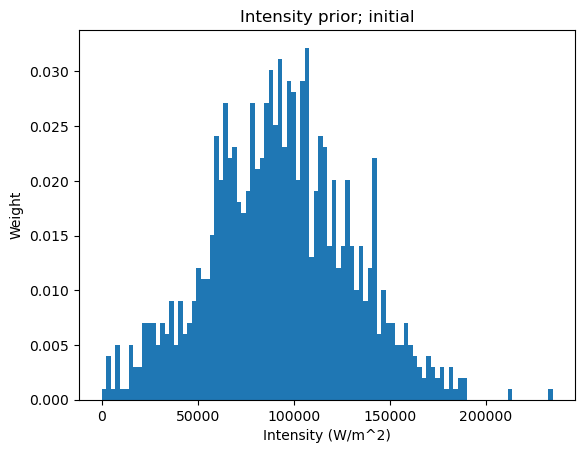

In [28]:
particles_I_binned, weights_I_binned, binwidth_I = bin_prior(particles[:,1], weights, 100)
fig = plt.figure()
plt.bar(particles_I_binned, weights_I_binned, width = binwidth_I)
plt.xlabel("Intensity (W/m^2)")
plt.ylabel("Weight")
plt.title("Intensity prior; initial")
plt.display(fig)
plt.close(fig)

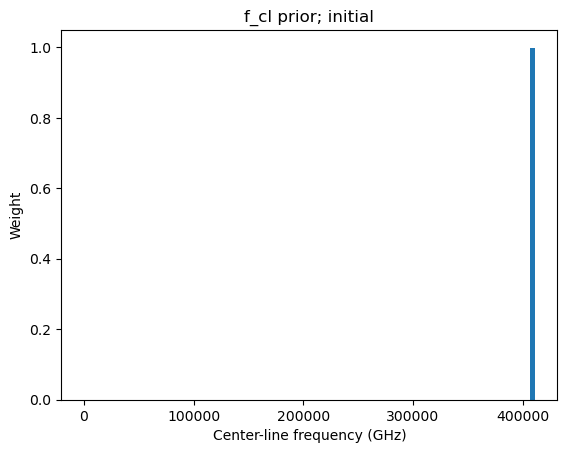

In [32]:
particles_f_cl_binned, weights_f_cl_binned, binwidth_f_cl = bin_prior(particles[:,2], weights, 100)
fig = plt.figure()
plt.bar(particles_f_cl_binned*1e-9, weights_f_cl_binned, width = binwidth_f_cl*1e-9)
plt.xlabel("Center-line frequency (GHz)")
plt.ylabel("Weight")
plt.title("f_cl prior; initial")
plt.display(fig)
plt.close(fig)

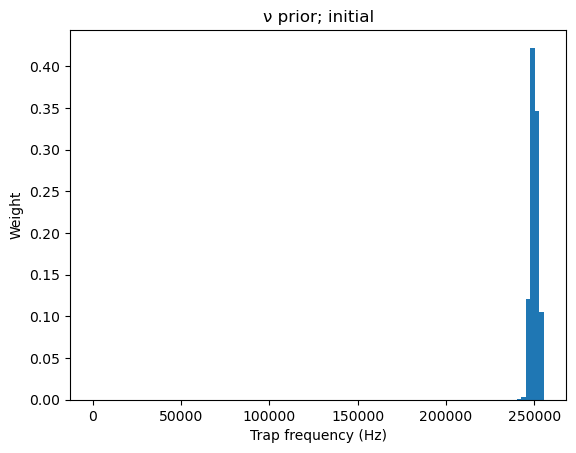

In [34]:
particles_ν_binned, weights_ν_binned, binwidth_ν = bin_prior(particles[:,3], weights, 100)
fig = plt.figure()
plt.bar(particles_ν_binned, weights_ν_binned, width = binwidth_ν)
plt.xlabel("Trap frequency (Hz)")
plt.ylabel("Weight")
plt.title("ν prior; initial")
plt.display(fig)
plt.close(fig)

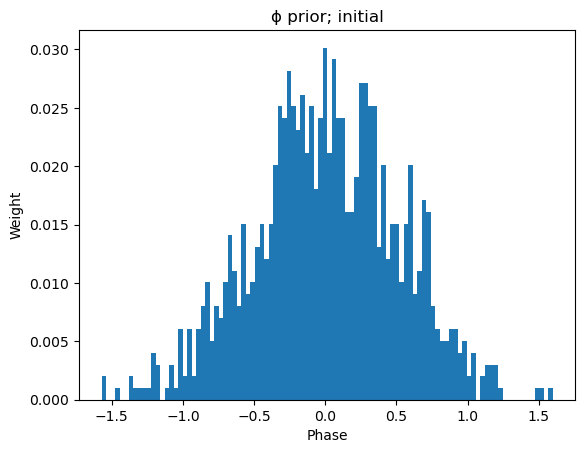

In [35]:
particles_ϕ_binned, weights_ϕ_binned, binwidth_ϕ = bin_prior(particles[:,4], weights, 100)
fig = plt.figure()
plt.bar(particles_ϕ_binned, weights_ϕ_binned, width = binwidth_ϕ)
plt.xlabel("Phase")
plt.ylabel("Weight")
plt.title("ϕ prior; initial")
plt.display(fig)
plt.close(fig)

The $\texttt{weights}$ distribution is what gets updated throughout the calibration process. At each sample point $\widetilde{\Theta}^{(i)} \in \texttt{particles}$, the relevant weight $w^{(i)} \in \texttt{weights\_1d}$ is updated according to:

$w_m^{(i)} \propto P(m|\widetilde{\Theta}^{(i)}) w^{(i)}$ 

(up to some normalization).

Now, we can't compute these $10000^4 = 10^8$ conditional probabilities. But we can compute $21^3 * 25 \approx 2.3e5$ (or maybe less) gridpoints, and then interpolate for the conditional probability of each particle from there. 

## 1.b. Compute $P(m|\Theta)$

### 1.b.i. Compute the 4D grid from which the conditional distribution is interpolated

### 1.b.i. Define our measurement protocol $m$

"We restrict our considerations to sequences of MS gates without any local operations. Besides the number of gates $N_g$ we can also intentionally introduce a phase difference $\Delta \varphi_{\text{target}}$ between the gates. We restrict the phase difference settings to either $\Delta \varphi_{\text{target}} = 0$ or $\Delta \varphi_{\text{target}} = \pm \pi/4$, corresponding to either consecutive $U_{\text{MS}}^0 (\pi/2)$ gates or a sequence of $U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^{\pm \pi/4} (\pi/2) ... U_{\text{MS}}^{\pm (N_g-1)\pi/4} (\pi/2) $ gates. We choose these two types of sequences as they change which parameters the sequence is most sensitive to (Fig. 6)."

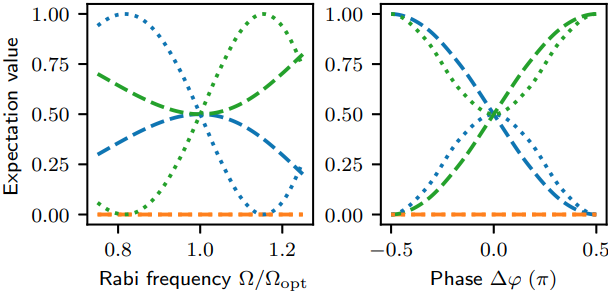

"FIG. 6. Expected outcome probabilities of $P(\ket{|g, g})$ (green), $P(\ket{|e, e})$  (blue), and $P(\ket{|e, g})  + P(\ket{|g, e})$ (orange) for a 3 $U_{\text{MS}}^0 (\pi/2)$ gate sequence (dotted) and for a $ U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^{\pi/4} (\pi/2) $ sequence (dashed). The first gate sequence is first-order insensitive to phase miscalibrations as the local minimum of the outcome probabilities around zero leads to only small variations in the likelihood of possible outcomes, and its symmetry around zero does not allow one to discriminate the sign of the miscalibration. Similar arguments can be used to see that this sequence is first-order sensitive to Rabi frequency miscalibrations. For the second gate sequence, the relation is inverted, being sensitive to phase miscalibrations at the cost of first-order insensitivity to the Rabi frequency. The qualitative behavior of the sensitivity of the center line matches the sensitivity of the phase difference, while the behavior of the sideband detuning matches the Rabi frequency."

Since we're not varying phase right now, let's stick with the first sequence of gates:
$N_g = 3 \Longrightarrow \boxed{m = U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^0 (\pi/2)} = U_{\text{MS}}^0 (3\pi/2)$

**TODO**: Consider a weighted-combination of Rabi-sensitive and phase-sensitive gates

**TODO**: Consider 50-50 split of $\psi_{\text{target}} = \frac{1}{\sqrt{2}} \left(\ket{00} + i\ket{11}\right)$ and $\psi_{\text{target}} = \frac{1}{\sqrt{2}} \left(\ket{01} + i\ket{10}\right)$ (or something else since this assumes perfect preparation of the initial state?)

### 1.b.ii. Compute $P(m|\widetilde{\Theta}^{(i)})$ by sampling $\texttt{particles\_I\_1d}$ and numerically integrating at that point.

**TODO:** Introduce depolarizing noise to account for SPAM error.

In [340]:
CONDITIONAL_I_DIST_COMPUTED = true

false

In [341]:
if CONDITIONAL_I_DIST_COMPUTED
    m_given_I_1d_dist = load_csv_to_matrix("m_given_I_1d_dist_$N_PARTICLES.csv")
else
    MS_CHAMBER_UNTUNED = construct_MS_chamber(
        TRAP_FREQUENCY,
        INTENSITY_MS,
        WAVELENGTH_CL_MS,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH
    )
    phase!(MS_CHAMBER_UNTUNED.lasers[1], 0)
    phase!(MS_CHAMBER_UNTUNED.lasers[2], 0)

    m_given_I_1d_dist = zeros((N_PARTICLES, 4))

    for i in 1:N_PARTICLES

        if i%Int(1e2)==0
            print("\n", i)
            flush(stdout)
        end

        I_i = particles_I_1d[i]
        update_intensity(MS_CHAMBER_UNTUNED, I_i)

        h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
        tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
        ρ_final = ptrace(dm(sol[end]),3)
        probs = ZZ_probs(ρ_final)
        probs = probs ./ sum(probs)
        m_given_I_1d_dist[i, :] = [p for p in probs]
        
    end
    writedlm("m_given_I_1d_dist_$N_PARTICLES.csv",  m_given_I_1d_dist, ',')
    CONDITIONAL_I_DIST_COMPUTED = true
end

true

In [53]:
using JLD2
zeros_4d = zeros((10,10,10,10));
jldsave("zeros_4d.jld", true; large_array = zeros_4d)

In [56]:
zeros_4d_loaded = load("zeros_4d.jld")["large_array"];

10×10×10×10 Array{Float64, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [48]:
using Pkg
Pkg.add("JLD2")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed JLD2 ─── v0.4.51
   Installed FileIO ─ v1.16.3
    Updating `~/.julia/environments/v1.10/Project.toml`
  [033835bb] + JLD2 v0.4.51
    Updating `~/.julia/environments/v1.10/Manifest.toml`
  [5789e2e9] + FileIO v1.16.3
  [033835bb] + JLD2 v0.4.51
Precompiling project...
  ✓ FileIO
  ✓ Plots → FileIOExt
  ✓ JLD2
  3 dependencies successfully precompiled in 25 seconds. 427 already precompiled.


In [45]:
zeros_4d_loaded = load_csv_to_matrix("m_given_I_1d_dist_$N_PARTICLES.csv");

1000×4 Matrix{Float64}:
 0.809938  0.18985   0.00010634   0.00010634
 0.117482  0.880803  0.000857687  0.000857687
 0.582739  0.416731  0.000264868  0.000264868
 0.448948  0.550286  0.000382729  0.000382729
 0.520772  0.478595  0.000316665  0.000316665
 0.485626  0.513677  0.000348106  0.000348106
 0.66312   0.336473  0.000203656  0.000203656
 0.767922  0.231813  0.00013245   0.00013245
 0.528865  0.470516  0.000309647  0.000309647
 0.425184  0.574003  0.000406256  0.000406256
 ⋮                                
 0.704039  0.295612  0.000174774  0.000174774
 0.140652  0.857736  0.000805895  0.000805895
 0.418929  0.580246  0.000412603  0.000412603
 0.256912  0.741875  0.000606497  0.000606497
 0.27462   0.724216  0.000581818  0.000581818
 0.65339   0.346188  0.000210741  0.000210741
 0.590895  0.408589  0.000258366  0.000258366
 0.502945  0.49639   0.000332412  0.000332412
 0.339691  0.65931   0.000499415  0.000499415

## 1.c. Calibrate

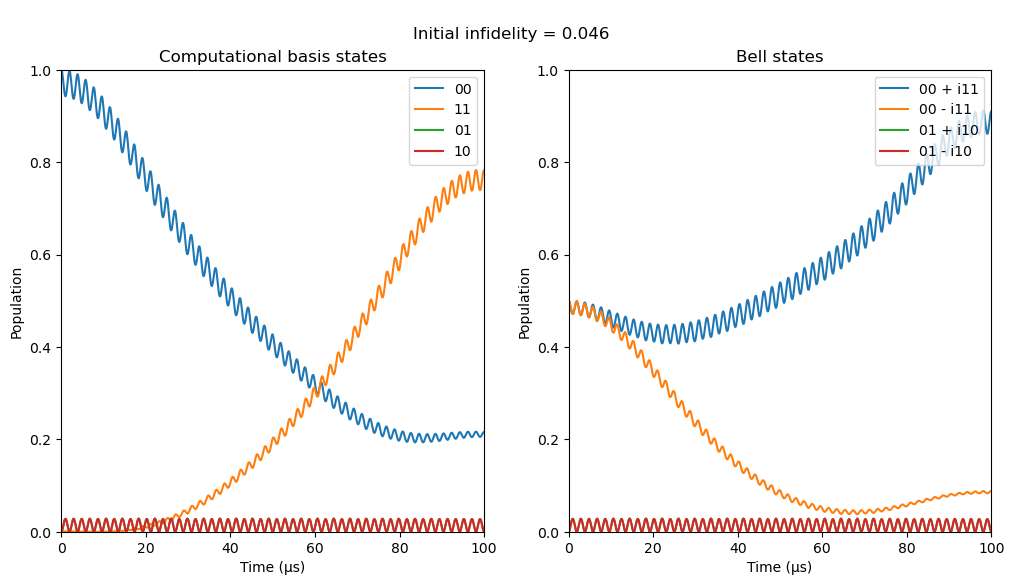

In [226]:
INFID_THRESH = 1.3e-2 # infidelity threshold
MAX_LOOPS = Int(1e3) # maximum number of loops
N_SHOTS = 100; # Number of shots per loop

# Initial theta
I_INITIAL = INTENSITY_MS + σ_I
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    TRAP_FREQUENCY,
    I_INITIAL,
    WAVELENGTH_CL_MS,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)

# Initial belief about theta
I_bar = sum(particles_I_1d .* weights_I_1d)

# Initial fidelity/infidelity
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = ptrace(dm(sol[end]),3)
fid = fidelity(ρ, ρ_00_p_i11)
infid = 1 - real(fid)

fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
infid_title = round(infid, digits=4)
plt.suptitle("\nInitial infidelity = $infid_title")
plt.display(fig)
plt.close(fig)

In [227]:
loop = 0
I_infid_tracker = []
I_tracker = [I_INITIAL]
I_bar_tracker = [I_bar]
while infid > INFID_THRESH
    loop += 1
    if loop > MAX_LOOPS
        infid = 0
    end

    if loop%Int(1e1)==0
        print("\n", loop)
        flush(stdout)
    end

    # Perform measurements 
    h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
    ρ = ptrace(dm(sol[end]),3)
    fid = fidelity(ρ, ρ_00_p_i11)
    infid = 1 - real(fid)
    probs = ZZ_probs(ρ)
    probs = probs ./ sum(probs)
    m_t = rand(Categorical([p for p in probs]), N_SHOTS)

    # Update beliefs
    for i in 1:N_PARTICLES 
        w_i = weights_I_1d[i]
        theta_i = particles_I_1d[i]
        p_m_given_I_1d_dist = m_given_I_1d_dist[i, :]
        p_m = mean(p_m_given_I_1d_dist[m_t])
        weights_I_1d[i] = w_i * p_m
    end
    weights_I_1d = weights_I_1d ./ sum(weights_I_1d)
    I_bar = sum(particles_I_1d .* weights_I_1d)
    
    # Update parameters
    I_new = compute_I_new(MS_CHAMBER_UNTUNED, I_bar)
    I = I_new
    update_intensity(MS_CHAMBER_UNTUNED, I)

    append!(I_infid_tracker, infid)
    append!(I_tracker, I_new)
    append!(I_bar_tracker, I_bar)
    print("\nI = ", I, ", I_bar = ", I_bar, ", infid = ", infid)
    flush(stdout)


end

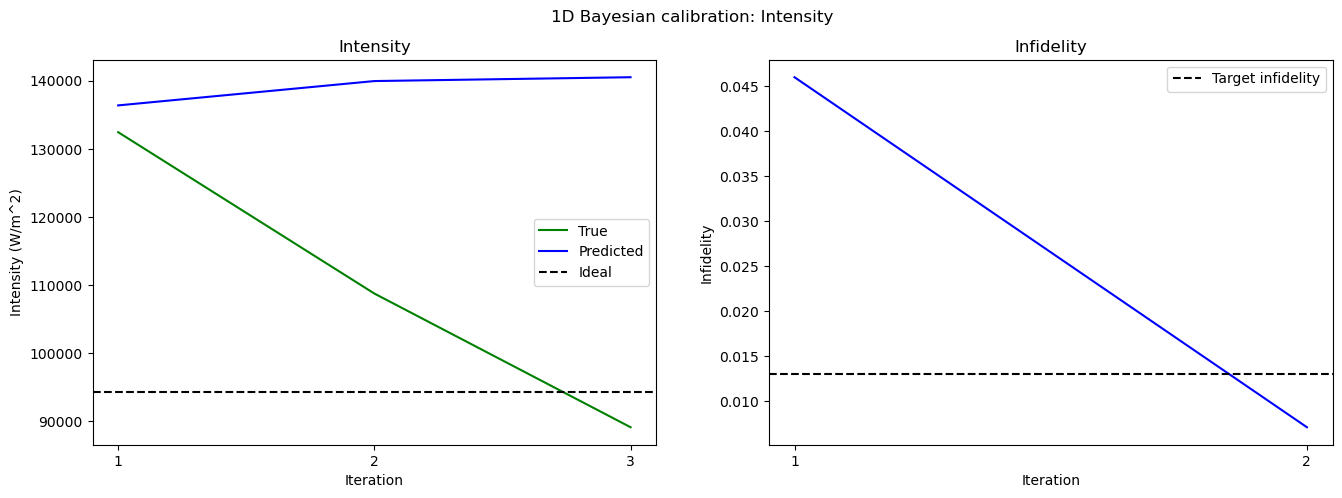

In [228]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

ax1.plot(1:length(I_tracker), I_tracker, color="g", label = "True")
ax1.plot(1:length(I_bar_tracker), I_bar_tracker, color="b", label = "Predicted")
ax1.axhline(INTENSITY_MS, color="k", linestyle="--", label = "Ideal")
ax1.set_xticks(ticks=1:length(I_tracker))
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Intensity (W/m^2)")
ax1.set_title("Intensity")
ax1.legend()


ax2.plot(1:length(I_infid_tracker), I_infid_tracker, color="b")
ax2.axhline(INFID_THRESH, label = "Target infidelity", color="k", linestyle="--")
ax2.set_xticks(ticks=1:length(I_infid_tracker))
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Infidelity")
ax2.set_title("Infidelity")
ax2.legend()

fig.suptitle("1D Bayesian calibration: Intensity")

plt.display(fig)
plt.close(fig)

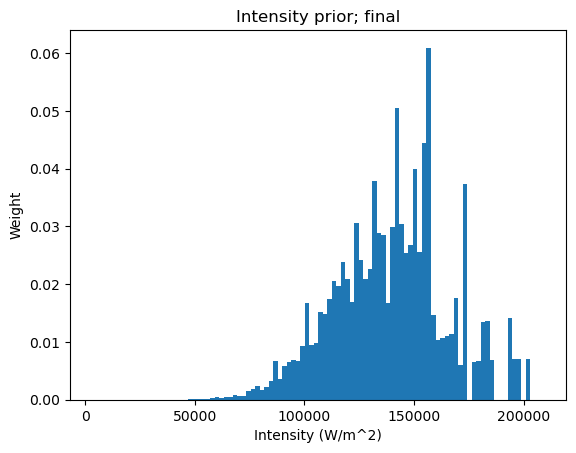

In [229]:
particles_I_1d_binned, weights_I_1d_binned, binwidth_I_1d = bin_prior(particles_I_1d, weights_I_1d, 100)
fig = plt.figure()
plt.bar(particles_I_1d_binned, weights_I_1d_binned, width = binwidth_I_1d)
plt.xlabel("Intensity (W/m^2)")
plt.ylabel("Weight")
plt.title("Intensity prior; final")
plt.display(fig)
plt.close(fig)

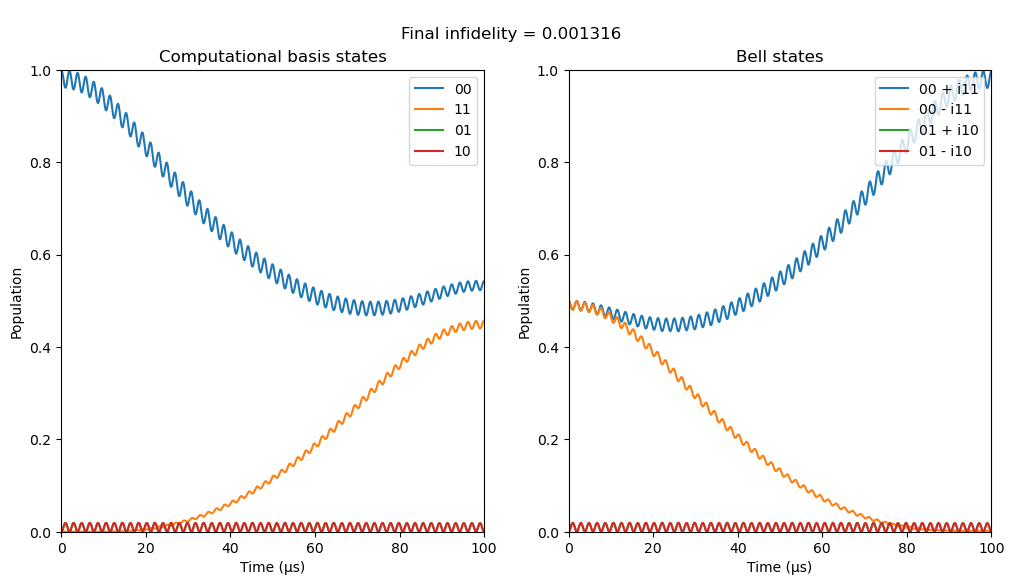

In [230]:
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = ptrace(dm(sol[end]),3)
fid = fidelity(ρ, ρ_00_p_i11)
infid = 1 - real(fid)
print("\nFinal infidelity = ", infid)

fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
infid_title = round(infid, digits=6)
plt.suptitle("\nFinal infidelity = $infid_title")
plt.display(fig)
plt.close(fig)

**IMPORTANT TODO:** Investigate runaway effect when $\texttt{I\_initial} < \texttt{INTENSITY\_MS}$ and $\texttt{INFID\_THRESH}$ is too small; recall Lukas: "the way you do the sampling is tricky, but important"